## About Me

This notebook has general analysis and the beginnings of using the tmdb database. 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tmdbsimple as tmdb
import os
import pickle
import time

In [3]:
with open('../Data/api_key.pkl', 'rb') as hnd:
    tmdb.API_KEY = pickle.load(hnd)['api_key']

In [4]:
search = tmdb.Search()
response = search.movie(query='The Bourne')
for s in search.results:
    print(s['title'], s['id'], s['release_date'], s['popularity'])

The Bourne Ultimatum 2503 2007-08-03 16.157
The Bourne Identity 2501 2002-06-14 15.613
The Bourne Legacy 49040 2012-08-08 15.147
The Bourne Supremacy 2502 2004-07-23 13.793
Bette Bourne: It Goes with the Shoes 179304 2013-03-21 0.847
Jason Bourne 324668 2016-07-27 14.053
Untitled Jeremy Renner/Bourne Sequel 393640  1.176


In [5]:
data = pd.read_csv('../Data/NetflixViewingHistory.csv')

In [6]:
data.shape

(1405, 2)

In [7]:
data.head()

,Title,Date
0,Dating Around: Season 1: Gurki,3/3/19
1,Dating Around: Season 1: Luke,3/3/19
2,The Umbrella Academy: Season 1: We Only See Ea...,2/19/19
3,Trevor Noah: Son of Patricia,11/23/18
4,American Vandal: Season 1: Nailed,11/19/18


In [8]:
data['TV_Show_flag'] = data.Title.apply(lambda x: 1 if ': Season' in x else 0 )

In [9]:
data['TV_Show_flag'].value_counts()

1    1291
0     114
Name: TV_Show_flag, dtype: int64

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
title_splits = data['Title'].str.split(':',2, expand=True)
title_splits.rename({0:'Show Name', 1:'Season', 2:'Episode Name'}, axis = 1, inplace=True)

In [12]:
data2 = pd.concat([data, title_splits], axis = 1)

In [13]:
data2.head()

,Title,Date,TV_Show_flag,Show Name,Season,Episode Name
0,Dating Around: Season 1: Gurki,2019-03-03,1,Dating Around,Season 1,Gurki
1,Dating Around: Season 1: Luke,2019-03-03,1,Dating Around,Season 1,Luke
2,The Umbrella Academy: Season 1: We Only See Ea...,2019-02-19,1,The Umbrella Academy,Season 1,We Only See Each Other at Weddings and Funerals
3,Trevor Noah: Son of Patricia,2018-11-23,0,Trevor Noah,Son of Patricia,None
4,American Vandal: Season 1: Nailed,2018-11-19,1,American Vandal,Season 1,Nailed


In [86]:
data2.shape

(1405, 6)

## Some Light Analysis 

In [14]:
data1 = data2.set_index('Date')

In [15]:
date_gb = data1.groupby(pd.Grouper(freq='W'))

In [16]:
date_gb.count().head()

,Title,TV_Show_flag,Show Name,Season,Episode Name
Date,,,,,
2013-09-15,2,2,2,2,2
2013-09-22,3,3,3,3,3
2013-09-29,0,0,0,0,0
2013-10-06,10,10,10,10,10
2013-10-13,7,7,7,7,7


In [17]:
date_gb['TV_Show_flag'].sum().head()

Date
2013-09-15     2
2013-09-22     3
2013-09-29     0
2013-10-06    10
2013-10-13     7
Freq: W-SUN, Name: TV_Show_flag, dtype: int64

In [18]:
watched_cnt = date_gb['Title'].count()
movie_sum = watched_cnt - date_gb['TV_Show_flag'].sum()

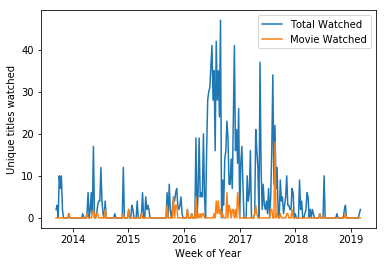

In [19]:
plt.plot(watched_cnt.index, watched_cnt.values, label='Total Watched')
plt.plot(movie_sum.index, movie_sum.values, label='Movie Watched')
plt.xlabel('Week of Year')
plt.ylabel('Unique titles watched')
plt.legend()
plt.show()

## Show name GB 

In [20]:
show_name_gb = data2.groupby('Show Name')

In [21]:
show_name_gb['Title'].count().sort_values(ascending=False).head()

Show Name
Friends                 171
30 Rock                 134
The Office (U.S.)       115
Parks and Recreation     90
White Collar             81
Name: Title, dtype: int64

In [22]:
show_gb_cnt = show_name_gb.size()
show_gb_first = show_name_gb['Date'].agg(['min'])['min']
show_gb_last = show_name_gb['Date'].agg(['max'])['max']

show_gb_any_tv_flag = show_name_gb['TV_Show_flag'].any()
show_gb_all_tv_flag = show_name_gb['TV_Show_flag'].all()

show_gb_dict = {"Count":show_gb_cnt, "Date of First Watched Show":show_gb_first,\
                "Date of Last Watched Show":show_gb_last, \
                "Any TV Flag":show_gb_any_tv_flag, "All TV Flag":show_gb_all_tv_flag}

In [23]:
show_gb_first.head()

Show Name
13TH                    2016-11-28
30 Rock                 2016-11-05
Altered Carbon          2018-03-18
American Dad!           2016-12-05
American Horror Story   2015-09-11
Name: min, dtype: datetime64[ns]

In [24]:
show_gb_any_tv_flag.head()

Show Name
13TH                     False
30 Rock                   True
Altered Carbon            True
American Dad!             True
American Horror Story    False
Name: TV_Show_flag, dtype: bool

In [25]:
sum(show_name_gb['TV_Show_flag'].all() != show_name_gb['TV_Show_flag'].any())

2

In [26]:
show_name_gb.size()[show_name_gb['TV_Show_flag'].all() != show_name_gb['TV_Show_flag'].any()]

Show Name
Chelsea       14
Marco Polo    11
dtype: int64

In [27]:
show_gb_metrics = pd.concat(show_gb_dict, axis=1)
show_gb_metrics.head()

,All TV Flag,Any TV Flag,Count,Date of First Watched Show,Date of Last Watched Show
Show Name,,,,,
13TH,False,False,1,2016-11-28,2016-11-28
30 Rock,True,True,134,2016-11-05,2017-09-23
Altered Carbon,True,True,10,2018-03-18,2018-03-24
American Dad!,True,True,1,2016-12-05,2016-12-05
American Horror Story,False,False,3,2015-09-11,2015-09-11


In [28]:
# Movies to Unique TV Shows 
show_gb_metrics['All TV Flag'].value_counts()

False    60
True     59
Name: All TV Flag, dtype: int64

## Try Search for all 

In [29]:
data2.iloc[0]

Title           Dating Around: Season 1: Gurki
Date                       2019-03-03 00:00:00
TV_Show_flag                                 1
Show Name                        Dating Around
Season                                Season 1
Episode Name                             Gurki
Name: 0, dtype: object

In [30]:
search = tmdb.Search()
response = search.movie(query='The Bourne')

In [31]:
type(response)

dict

In [32]:
def search_results_iter(tv_row):
#     print(tv_row)
    tv_row = tv_row[1]
    if tv_row['TV_Show_flag'] == 1:
        res = search.tv(query=tv_row['Show Name'])
    else:
        res = search.movie(query=tv_row['Show Name'])
        
    # Per API Docs, can only submit 40 requests every 10s 
    # So 4 requests a second or 1 request every 0.25 s 
    time.sleep(0.3)
    try:
        res_pt2 = res['results'][0]
    except:
        res_pt2 = np.nan
    return(res_pt2)

In [33]:
def search_results(tv_row):
    print(tv_row)
    if tv_row['TV_Show_flag'] == 1:
        res = search.tv(query=tv_row['Show Name'])
    else:
        res = search.movie(query=tv_row['Show Name'])
    # Per API Docs, can only submit 40 requests every 10s 
    # So 4 requests a second or 1 request every 0.25 s 
    time.sleep(0.3)
    res_pt2 = res['results'][0]
#     out = pd.DataFrame.from_dict(res_pt2, 'index')
#     return(pd.DataFrame.from_dict(res_pt2, 'index').T)
    print(res_pt2)
    return(res_pt2)

In [34]:
demo1 = data2.iloc[:4].apply(search_results,axis=1)

Title           Dating Around: Season 1: Gurki
Date                       2019-03-03 00:00:00
TV_Show_flag                                 1
Show Name                        Dating Around
Season                                Season 1
Episode Name                             Gurki
Name: 0, dtype: object
{'original_name': 'Dating Around', 'id': 86807, 'name': 'Dating Around', 'vote_count': 1, 'vote_average': 6, 'poster_path': '/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg', 'first_air_date': '2019-02-14', 'popularity': 1.198, 'genre_ids': [10764], 'original_language': 'en', 'backdrop_path': '/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg', 'overview': 'In each episode of flirtations and fails, one real-life single navigates five blind dates. The mission: Find one match worthy of a second date.', 'origin_country': []}
Title           Dating Around: Season 1: Luke
Date                      2019-03-03 00:00:00
TV_Show_flag                                1
Show Name                       Dating Around
Season         

In [35]:
# It runs but doesn't come out as expected 
demo1.head()

0    {'original_name': 'Dating Around', 'id': 86807...
1    {'original_name': 'Dating Around', 'id': 86807...
2    {'original_name': 'The Umbrella Academy', 'id'...
3    {'vote_count': 35, 'id': 558341, 'video': Fals...
dtype: object

In [36]:
time.sleep(0.3)

## Get results

In [37]:
# Load existing file
with open('../Data/SearchResults_list.pkl', 'rb') as hnd:
    all_search_results = pickle.load(hnd)
print("Loaded pickle type: ", type(all_search_results))
print("Pickle keys: ", all_search_results.keys())
print("final object type: ",type(all_search_results['all_search_results_list']))
results = all_search_results['all_search_results_list']

Loaded pickle type:  <class 'dict'>
Pickle keys:  dict_keys(['all_search_results_list'])
final object type:  <class 'list'>


In [38]:
results[:2]

[{'original_name': 'Dating Around',
  'id': 86807,
  'name': 'Dating Around',
  'vote_count': 1,
  'vote_average': 6,
  'poster_path': '/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg',
  'first_air_date': '2019-02-14',
  'popularity': 1.047,
  'genre_ids': [10764],
  'original_language': 'en',
  'backdrop_path': '/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg',
  'overview': 'In each episode of flirtations and fails, one real-life single navigates five blind dates. The mission: Find one match worthy of a second date.',
  'origin_country': []},
 {'original_name': 'Dating Around',
  'id': 86807,
  'name': 'Dating Around',
  'vote_count': 1,
  'vote_average': 6,
  'poster_path': '/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg',
  'first_air_date': '2019-02-14',
  'popularity': 1.047,
  'genre_ids': [10764],
  'original_language': 'en',
  'backdrop_path': '/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg',
  'overview': 'In each episode of flirtations and fails, one real-life single navigates five blind dates. The mission: Find one match worthy o

In [39]:
all_search_results.keys()

dict_keys(['all_search_results_list'])

In [40]:
def demo_search_results(tv_row):
    if tv_row['TV_Show_flag'] == 1:
#         res = search.tv(query=tv_row['Show Name'])
        res = "Show: "+tv_row['Show Name']
    else:
#         res = search.movie(query=tv_row['Show Name'])
        res = ["Movie: "+tv_row['Show Name'], 2]
    time.sleep(0.3)
    return({'name1':res})

In [41]:
data2.iloc[:4][['TV_Show_flag', 'Show Name']].apply(demo_search_results,axis =1)

0           {'name1': 'Show: Dating Around'}
1           {'name1': 'Show: Dating Around'}
2    {'name1': 'Show: The Umbrella Academy'}
3       {'name1': ['Movie: Trevor Noah', 2]}
dtype: object

## Continue parsing results

In [42]:
df_results = [pd.Series(x) for x in results]

In [43]:
df = pd.concat(df_results, axis =1).T

In [44]:
df.head()

,0,adult,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,NaN,"In each episode of flirtations and fails, one ...",1.047,/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg,NaN,NaN,NaN,6,1
1,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,NaN,"In each episode of flirtations and fails, one ...",1.047,/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg,NaN,NaN,NaN,6,1
2,NaN,NaN,/mE3zzMkpP8yqlkzdjPsQmJHceoe.jpg,2019-02-15,"[10759, 10765]",75006,The Umbrella Academy,"[CA, US]",en,The Umbrella Academy,NaN,A dysfunctional family of superheroes comes to...,59.649,/uYHdIs5O8tiU5p6MvUPd2jElOH6.jpg,NaN,NaN,NaN,7.81,101
3,NaN,False,/hDd2RWYR0mwGeF5oms5Ulr9zrhh.jpg,NaN,"[35, 10770]",558341,NaN,NaN,en,NaN,Trevor Noah: Son of Patricia,"Trevor Noah gets out from behind the ""Daily Sh...",2.548,/dmhDeV3RYq4jMwgIMmo0W05uH8L.jpg,2018-11-20,Trevor Noah: Son of Patricia,False,7.1,34
4,NaN,NaN,/yWlcrp0pBvnxRpPrZUrAX0Sh2B9.jpg,2017-09-15,"[35, 80]",73126,American Vandal,[US],en,American Vandal,NaN,A true-crime satire that explores the aftermat...,8.757,/z1vnHi6L2VqB620vT33sdChuIhX.jpg,NaN,NaN,NaN,7.88,64


In [45]:
df.shape

(1405, 19)

In [46]:
df.columns

Index([                  0,             'adult',     'backdrop_path',
          'first_air_date',         'genre_ids',                'id',
                    'name',    'origin_country', 'original_language',
           'original_name',    'original_title',          'overview',
              'popularity',       'poster_path',      'release_date',
                   'title',             'video',      'vote_average',
              'vote_count'],
      dtype='object')

In [47]:
df.head()

,0,adult,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,NaN,"In each episode of flirtations and fails, one ...",1.047,/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg,NaN,NaN,NaN,6,1
1,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,NaN,"In each episode of flirtations and fails, one ...",1.047,/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg,NaN,NaN,NaN,6,1
2,NaN,NaN,/mE3zzMkpP8yqlkzdjPsQmJHceoe.jpg,2019-02-15,"[10759, 10765]",75006,The Umbrella Academy,"[CA, US]",en,The Umbrella Academy,NaN,A dysfunctional family of superheroes comes to...,59.649,/uYHdIs5O8tiU5p6MvUPd2jElOH6.jpg,NaN,NaN,NaN,7.81,101
3,NaN,False,/hDd2RWYR0mwGeF5oms5Ulr9zrhh.jpg,NaN,"[35, 10770]",558341,NaN,NaN,en,NaN,Trevor Noah: Son of Patricia,"Trevor Noah gets out from behind the ""Daily Sh...",2.548,/dmhDeV3RYq4jMwgIMmo0W05uH8L.jpg,2018-11-20,Trevor Noah: Son of Patricia,False,7.1,34
4,NaN,NaN,/yWlcrp0pBvnxRpPrZUrAX0Sh2B9.jpg,2017-09-15,"[35, 80]",73126,American Vandal,[US],en,American Vandal,NaN,A true-crime satire that explores the aftermat...,8.757,/z1vnHi6L2VqB620vT33sdChuIhX.jpg,NaN,NaN,NaN,7.88,64


In [48]:
data2.head()

,Title,Date,TV_Show_flag,Show Name,Season,Episode Name
0,Dating Around: Season 1: Gurki,2019-03-03,1,Dating Around,Season 1,Gurki
1,Dating Around: Season 1: Luke,2019-03-03,1,Dating Around,Season 1,Luke
2,The Umbrella Academy: Season 1: We Only See Ea...,2019-02-19,1,The Umbrella Academy,Season 1,We Only See Each Other at Weddings and Funerals
3,Trevor Noah: Son of Patricia,2018-11-23,0,Trevor Noah,Son of Patricia,None
4,American Vandal: Season 1: Nailed,2018-11-19,1,American Vandal,Season 1,Nailed


In [49]:
# Need to find better way to merge these two datasets 
# If something doesn't come back with a result... what then ... look out for misalignments 
combo_data = pd.concat([df, data2], axis =1)

In [50]:
combo_data.shape

(1405, 25)

In [85]:
combo_data.head()

,0,adult,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,...,title,video,vote_average,vote_count,Title,Date,TV_Show_flag,Show Name,Season,Episode Name
0,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,...,NaN,NaN,6,1,Dating Around: Season 1: Gurki,2019-03-03,1,Dating Around,Season 1,Gurki
1,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,...,NaN,NaN,6,1,Dating Around: Season 1: Luke,2019-03-03,1,Dating Around,Season 1,Luke
2,NaN,NaN,/mE3zzMkpP8yqlkzdjPsQmJHceoe.jpg,2019-02-15,"[10759, 10765]",75006,The Umbrella Academy,"[CA, US]",en,The Umbrella Academy,...,NaN,NaN,7.81,101,The Umbrella Academy: Season 1: We Only See Ea...,2019-02-19,1,The Umbrella Academy,Season 1,We Only See Each Other at Weddings and Funerals
3,NaN,False,/hDd2RWYR0mwGeF5oms5Ulr9zrhh.jpg,NaN,"[35, 10770]",558341,NaN,NaN,en,NaN,...,Trevor Noah: Son of Patricia,False,7.1,34,Trevor Noah: Son of Patricia,2018-11-23,0,Trevor Noah,Son of Patricia,None
4,NaN,NaN,/yWlcrp0pBvnxRpPrZUrAX0Sh2B9.jpg,2017-09-15,"[35, 80]",73126,American Vandal,[US],en,American Vandal,...,NaN,NaN,7.88,64,American Vandal: Season 1: Nailed,2018-11-19,1,American Vandal,Season 1,Nailed


In [51]:
combo_data.head()

,0,adult,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,...,title,video,vote_average,vote_count,Title,Date,TV_Show_flag,Show Name,Season,Episode Name
0,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,...,NaN,NaN,6,1,Dating Around: Season 1: Gurki,2019-03-03,1,Dating Around,Season 1,Gurki
1,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,...,NaN,NaN,6,1,Dating Around: Season 1: Luke,2019-03-03,1,Dating Around,Season 1,Luke
2,NaN,NaN,/mE3zzMkpP8yqlkzdjPsQmJHceoe.jpg,2019-02-15,"[10759, 10765]",75006,The Umbrella Academy,"[CA, US]",en,The Umbrella Academy,...,NaN,NaN,7.81,101,The Umbrella Academy: Season 1: We Only See Ea...,2019-02-19,1,The Umbrella Academy,Season 1,We Only See Each Other at Weddings and Funerals
3,NaN,False,/hDd2RWYR0mwGeF5oms5Ulr9zrhh.jpg,NaN,"[35, 10770]",558341,NaN,NaN,en,NaN,...,Trevor Noah: Son of Patricia,False,7.1,34,Trevor Noah: Son of Patricia,2018-11-23,0,Trevor Noah,Son of Patricia,None
4,NaN,NaN,/yWlcrp0pBvnxRpPrZUrAX0Sh2B9.jpg,2017-09-15,"[35, 80]",73126,American Vandal,[US],en,American Vandal,...,NaN,NaN,7.88,64,American Vandal: Season 1: Nailed,2018-11-19,1,American Vandal,Season 1,Nailed


In [52]:
combo_data.tail()

,0,adult,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,...,title,video,vote_average,vote_count,Title,Date,TV_Show_flag,Show Name,Season,Episode Name
1400,NaN,NaN,/gn18IaampxKKRgxSrCJORhWi84J.jpg,2001-10-02,"[18, 35]",4556,Scrubs,[US],en,Scrubs,...,NaN,NaN,7.84,568,Scrubs: Season 7: My Waste of Time,2013-09-20,1,Scrubs,Season 7,My Waste of Time
1401,NaN,NaN,/gn18IaampxKKRgxSrCJORhWi84J.jpg,2001-10-02,"[18, 35]",4556,Scrubs,[US],en,Scrubs,...,NaN,NaN,7.84,568,Scrubs: Season 7: My Dumb Luck,2013-09-20,1,Scrubs,Season 7,My Dumb Luck
1402,NaN,NaN,/gn18IaampxKKRgxSrCJORhWi84J.jpg,2001-10-02,"[18, 35]",4556,Scrubs,[US],en,Scrubs,...,NaN,NaN,7.84,568,Scrubs: Season 7: My Manhood,2013-09-20,1,Scrubs,Season 7,My Manhood
1403,NaN,NaN,/xDYTP6NQSY7XYxs3qLgVIVKBE2m.jpg,2010-01-11,[35],31941,Blue Mountain State,[US],en,Blue Mountain State,...,NaN,NaN,7.16,73,Blue Mountain State: Season 3: Superstition,2013-09-14,1,Blue Mountain State,Season 3,Superstition
1404,NaN,NaN,/xDYTP6NQSY7XYxs3qLgVIVKBE2m.jpg,2010-01-11,[35],31941,Blue Mountain State,[US],en,Blue Mountain State,...,NaN,NaN,7.16,73,Blue Mountain State: Season 3: Blackout,2013-09-14,1,Blue Mountain State,Season 3,Blackout


In [53]:
combo_data.columns

Index([                  0,             'adult',     'backdrop_path',
          'first_air_date',         'genre_ids',                'id',
                    'name',    'origin_country', 'original_language',
           'original_name',    'original_title',          'overview',
              'popularity',       'poster_path',      'release_date',
                   'title',             'video',      'vote_average',
              'vote_count',             'Title',              'Date',
            'TV_Show_flag',         'Show Name',            'Season',
            'Episode Name'],
      dtype='object')

In [54]:
combo_smaller = combo_data.drop(['genre_ids', 'origin_country'], axis =1)
combo_metrics_raw = {"sum NA":combo_smaller.isna().sum(), "nunique":combo_smaller.nunique()}

In [55]:
pd.concat(combo_metrics_raw, axis=1)

,nunique,sum NA
0,0,1405
adult,1,1305
backdrop_path,113,40
first_air_date,60,114
id,119,14
name,61,114
original_language,4,14
original_name,61,114
original_title,58,1305
overview,119,14


In [56]:
combo_data_small = combo_data.iloc[:5]

In [57]:
show_name_id_tmdb = combo_data.groupby('Show Name')[['id', 'TV_Show_flag']].agg('max')

In [58]:
show_name_id_tmdb.head(10)

,id,TV_Show_flag
Show Name,,
13TH,407806.0,0
30 Rock,4608.0,1
Altered Carbon,68421.0,1
American Dad!,1433.0,1
American Horror Story,492815.0,0
American Vandal,73126.0,1
Archer,10283.0,1
Arrow,1412.0,1
Atypical,71578.0,1


In [59]:
small_show_name_id_tmdb = show_name_id_tmdb.iloc[:5]

In [60]:
small_show_name_id_tmdb

,id,TV_Show_flag
Show Name,,
13TH,407806.0,0
30 Rock,4608.0,1
Altered Carbon,68421.0,1
American Dad!,1433.0,1
American Horror Story,492815.0,0


In [61]:
combo_data_small.head()

,0,adult,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,...,title,video,vote_average,vote_count,Title,Date,TV_Show_flag,Show Name,Season,Episode Name
0,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,...,NaN,NaN,6,1,Dating Around: Season 1: Gurki,2019-03-03,1,Dating Around,Season 1,Gurki
1,NaN,NaN,/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg,2019-02-14,[10764],86807,Dating Around,[],en,Dating Around,...,NaN,NaN,6,1,Dating Around: Season 1: Luke,2019-03-03,1,Dating Around,Season 1,Luke
2,NaN,NaN,/mE3zzMkpP8yqlkzdjPsQmJHceoe.jpg,2019-02-15,"[10759, 10765]",75006,The Umbrella Academy,"[CA, US]",en,The Umbrella Academy,...,NaN,NaN,7.81,101,The Umbrella Academy: Season 1: We Only See Ea...,2019-02-19,1,The Umbrella Academy,Season 1,We Only See Each Other at Weddings and Funerals
3,NaN,False,/hDd2RWYR0mwGeF5oms5Ulr9zrhh.jpg,NaN,"[35, 10770]",558341,NaN,NaN,en,NaN,...,Trevor Noah: Son of Patricia,False,7.1,34,Trevor Noah: Son of Patricia,2018-11-23,0,Trevor Noah,Son of Patricia,None
4,NaN,NaN,/yWlcrp0pBvnxRpPrZUrAX0Sh2B9.jpg,2017-09-15,"[35, 80]",73126,American Vandal,[US],en,American Vandal,...,NaN,NaN,7.88,64,American Vandal: Season 1: Nailed,2018-11-19,1,American Vandal,Season 1,Nailed


In [62]:
def search_results_iter(tv_row):
#     print(tv_row)
    tv_row = tv_row[1]
    if tv_row['TV_Show_flag'] == 1:
        res = search.tv(query=tv_row['Show Name'])
    else:
        res = search.movie(query=tv_row['Show Name'])
        
    # Per API Docs, can only submit 40 requests every 10s 
    # So 4 requests a second or 1 request every 0.25 s 
    time.sleep(0.3)
    try:
        res_pt2 = res['results'][0]
    except:
        res_pt2 = np.nan
    return(res_pt2)

In [63]:
def get_full_TV_response(tv_row):
    tv_row = tv_row[1]
    if tv_row['TV_Show_flag'] == 1:
        res = tmdb.TV(tv_row['id']).info()
    else:
        res = tmdb.Movies(tv_row['id']).info()
    
    return(res)

In [64]:
# Full results for small dataset 
full_results = [get_full_TV_response(tv_row) for tv_row in small_show_name_id_tmdb.iterrows()]

In [65]:
full_results

[{'adult': False,
  'backdrop_path': '/fhSkVpRCg5s9b8nmdSS77Q1onhv.jpg',
  'belongs_to_collection': None,
  'budget': 0,
  'genres': [{'id': 99, 'name': 'Documentary'}],
  'homepage': None,
  'id': 407806,
  'imdb_id': 'tt5895028',
  'original_language': 'en',
  'original_title': '13th',
  'overview': "An in-depth look at the prison system in the United States and how it reveals the nation's history of racial inequality.",
  'popularity': 7.026,
  'poster_path': '/tcKNWD6IFPPsvkpvyZ548naz0is.jpg',
  'production_companies': [{'id': 82852,
    'logo_path': None,
    'name': 'Kandoo Films',
    'origin_country': 'US'}],
  'production_countries': [{'iso_3166_1': 'US',
    'name': 'United States of America'}],
  'release_date': '2016-10-07',
  'revenue': 0,
  'runtime': 100,
  'spoken_languages': [{'iso_639_1': 'en', 'name': 'English'}],
  'status': 'Released',
  'tagline': 'From slave to criminal with one amendment',
  'title': '13th',
  'video': False,
  'vote_average': 8.0,
  'vote_count

In [66]:
tv_resp = tmdb.TV(68421)

In [67]:
# results = [search_results_iter(tv_row) for tv_row in data2.iterrows()]
# with open('full_search_results.pkl', 'wb') as hnd:
#     pickle.dump(results, hnd)

In [68]:
with open('full_search_results.pkl', 'rb') as hnd:
    results = pickle.load(hnd)

In [69]:
type(results)

list

In [70]:
len(results)

1405

In [71]:
results[:3]

[{'original_name': 'Dating Around',
  'id': 86807,
  'name': 'Dating Around',
  'vote_count': 1,
  'vote_average': 6,
  'poster_path': '/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg',
  'first_air_date': '2019-02-14',
  'popularity': 1.047,
  'genre_ids': [10764],
  'original_language': 'en',
  'backdrop_path': '/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg',
  'overview': 'In each episode of flirtations and fails, one real-life single navigates five blind dates. The mission: Find one match worthy of a second date.',
  'origin_country': []},
 {'original_name': 'Dating Around',
  'id': 86807,
  'name': 'Dating Around',
  'vote_count': 1,
  'vote_average': 6,
  'poster_path': '/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg',
  'first_air_date': '2019-02-14',
  'popularity': 1.047,
  'genre_ids': [10764],
  'original_language': 'en',
  'backdrop_path': '/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg',
  'overview': 'In each episode of flirtations and fails, one real-life single navigates five blind dates. The mission: Find one match worthy o

In [72]:
tv_resp.info()

{'backdrop_path': '/xETbCo8l06poxFUgbtaUeKmLadz.jpg',
 'created_by': [{'id': 20294,
   'credit_id': '581280ecc3a3687477018c1e',
   'name': 'Laeta Kalogridis',
   'profile_path': '/vfC4zu2BU6zAABpQZTnzbya2OGU.jpg'}],
 'episode_run_time': [60],
 'first_air_date': '2018-02-02',
 'genres': [{'id': 80, 'name': 'Crime'},
  {'id': 9648, 'name': 'Mystery'},
  {'id': 10765, 'name': 'Sci-Fi & Fantasy'},
  {'id': 18, 'name': 'Drama'}],
 'homepage': 'https://www.netflix.com/title/80097140',
 'id': 68421,
 'in_production': True,
 'languages': ['en'],
 'last_air_date': '2018-02-02',
 'last_episode_to_air': {'air_date': '2018-02-02',
  'episode_number': 10,
  'id': 1402150,
  'name': 'The Killers',
  'overview': 'As a cornered Kovacs braces for a final showdown in the sky, a new hero emerges and more buried secrets come to light.',
  'production_code': '',
  'season_number': 1,
  'show_id': 68421,
  'still_path': '/6rs8oCBfY7ohnhPjOEYT3dnMrUf.jpg',
  'vote_average': 7.571,
  'vote_count': 14},
 'name

In [73]:
tv_resp.info()['episode_run_time'][0]

60

In [74]:
movie_resp = tmdb.Movies(427451)

In [75]:
movie_resp.info()

{'adult': False,
 'backdrop_path': '/3HnawxURqLnl05rNDWwps28eepp.jpg',
 'belongs_to_collection': None,
 'budget': 100000,
 'genres': [{'id': 99, 'name': 'Documentary'}, {'id': 36, 'name': 'History'}],
 'homepage': 'https://invisiblemoneydocumentary.wordpress.com/',
 'id': 427451,
 'imdb_id': 'tt5033790',
 'original_language': 'en',
 'original_title': 'Banking on Bitcoin',
 'overview': "Not since the invention of the Internet has there been such a disruptive technology as Bitcoin. Bitcoin's early pioneers sought to blur the lines of sovereignty and the financial status quo. After years of underground development Bitcoin grabbed the attention of a curious public, and the ire of the regulators the technology had subverted. After landmark arrests of prominent cyber criminals Bitcoin faces its most severe adversary yet, the very banks it was built to destroy.",
 'popularity': 2.504,
 'poster_path': '/umnDgaJ0XFcxaXWhV76ksOtDddw.jpg',
 'production_companies': [{'id': 83693,
   'logo_path': N

In [76]:
movie_resp.info()['runtime']

90

In [82]:
tv_details.info()

{'air_date': '2019-02-14',
 'crew': [],
 'episode_number': 1,
 'guest_stars': [],
 'name': 'Luke',
 'overview': "He may be a ladies' man, but Luke is ready to settle down -- after some light drinking, deep kissing and one date's awkward-but-adorable door snafu.",
 'id': 1707145,
 'production_code': '',
 'season_number': 1,
 'still_path': None,
 'vote_average': 0.0,
 'vote_count': 0}

In [83]:
tv_season_details = tmdb.TV_Seasons(86807,1)

In [84]:
tv_season_details.info()

{'_id': '5c6524ac0e0a2625d197ba24',
 'air_date': '2019-02-14',
 'episodes': [{'air_date': '2019-02-14',
   'episode_number': 1,
   'id': 1707145,
   'name': 'Luke',
   'overview': "He may be a ladies' man, but Luke is ready to settle down -- after some light drinking, deep kissing and one date's awkward-but-adorable door snafu.",
   'production_code': '',
   'season_number': 1,
   'show_id': 86807,
   'still_path': None,
   'vote_average': 0.0,
   'vote_count': 0,
   'crew': [],
   'guest_stars': []},
  {'air_date': '2019-02-14',
   'episode_number': 2,
   'id': 1707146,
   'name': 'Gurki',
   'overview': 'Fiercely independent Gurki is eager to open up about divorce, until one date radically challenges her candor. Will she back down or speak her mind?',
   'production_code': '',
   'season_number': 1,
   'show_id': 86807,
   'still_path': None,
   'vote_average': 0.0,
   'vote_count': 0,
   'crew': [],
   'guest_stars': []},
  {'air_date': '2019-02-14',
   'episode_number': 3,
   'id':

In [75]:
response1 = tv_details.info()

In [76]:
response1

{'air_date': '2019-02-14',
 'crew': [],
 'episode_number': 1,
 'guest_stars': [],
 'name': 'Luke',
 'overview': "He may be a ladies' man, but Luke is ready to settle down -- after some light drinking, deep kissing and one date's awkward-but-adorable door snafu.",
 'id': 1707145,
 'production_code': '',
 'season_number': 1,
 'still_path': None,
 'vote_average': 0.0,
 'vote_count': 0}

In [77]:
dir(tv_details)

['BASE_PATH',
 'URLS',
 '_DELETE',
 '_GET',
 '_POST',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_complete_url',
 '_get_credit_id_path',
 '_get_guest_session_id_path',
 '_get_id_path',
 '_get_params',
 '_get_path',
 '_get_series_id_season_number_episode_number_path',
 '_get_series_id_season_number_path',
 '_request',
 '_set_attrs_to_values',
 'air_date',
 'base_uri',
 'credits',
 'crew',
 'episode_number',
 'external_ids',
 'guest_stars',
 'headers',
 'id',
 'images',
 'info',
 'name',
 'overview',
 'production_code',
 'rating',
 'season_number',
 'series_id',
 'still_path',
 'videos',
 'vote_average',
 'vote_count']

In [78]:
type(results)

list

In [79]:
results = all_search_results['all_search_results_list']

In [80]:
all_search_results.keys()

dict_keys(['all_search_results_list'])

In [81]:
type(all_search_results)

dict

In [82]:
# all_search_results = data2.apply(lambda x:search_results(x))
with open('../Data/SearchResults_list.pkl', 'rb') as hnd:
    all_search_results = pickle.load(hnd)

In [85]:
type(all_search_results)

dict

In [90]:
all_search_results['all_search_results_list'][0]

{'original_name': 'Dating Around',
 'id': 86807,
 'name': 'Dating Around',
 'vote_count': 1,
 'vote_average': 6,
 'poster_path': '/8Bylu6ne7GRLzdfKEDwWJNfZugP.jpg',
 'first_air_date': '2019-02-14',
 'popularity': 1.047,
 'genre_ids': [10764],
 'original_language': 'en',
 'backdrop_path': '/fcdqZ9wfQaRqhJraXVHPyZppxWy.jpg',
 'overview': 'In each episode of flirtations and fails, one real-life single navigates five blind dates. The mission: Find one match worthy of a second date.',
 'origin_country': []}